# RDPS 🅱

<style>
  .beta-badge {
    background-color: #f39c12;
    color: white;
    padding: 4px 8px;
    border-radius: 4px;
    font-weight: bold;
  }
</style>

<span class="beta-badge">BETA</span>
<span class="beta-badge">Requires MetPy >=1.6</span>

This demonstrates using data from Canada's GEM Regional or Regional Deterministic Prediction System (RDPS).

[RDPS Model Description](https://eccc-msc.github.io/open-data/msc-data/nwp_rdps/readme_rdps-datamart_en/#data-location)


**Data Sources**

|`prioriy=`|Data source| Archive Duration|
|--|--|--|
|`"mcs"` | [Meteorological Service of Canada](https://dd.weather.gc.ca/model_gem_regional/) | Last 24 hours

**Model Initialization**

Model cyles every six hours.

**Forecast Hour**

For the most recent version of RDPS...

|`fxx=`|Forecast lead time|
|--|--|
|`0` through `84`, step=1| hourly forecasts available


**Products**

|`product=`| Product Description |    
|--|--|
|`"10km/grib2"`| Regional domain

**Variable and Level**

You will need to specify the variable and level for each request. 

<br>


> **NOTE:** The organization of these files is different than other NWP products.
>
> 1. There are no index files provided.
> 1. Each GRIB2 file only contains one message. The variable name and level is in the file's name.
>
> Herbie requires you provide a keyword argument for both `variable` and `level`. Pay special attention to model description (linked above) to understand how the model data is organized. If you don't provide input for `variable` or `level`, Herbie will give you some ideas. For example, `variable=TMP` and `level=TGL_2` will give you the filename that contains
>
> ```
> TMP_TGL_2
> ```

> **Note:** This requires MetPy version 1.6 or greater which has the capability to parse the _rotated latitude longitude_ map projection type (see [MetPy/#3123](https://github.com/Unidata/MetPy/pull/3123)).


In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

recent = pd.Timestamp("now").floor("12h") - pd.Timedelta("12h")

In [2]:
# Some examples

H = Herbie(
    recent,  # Datetime
    model="rdps",
    fxx=32,
    variable="TMP",
    level="TGL_2",
)
H.grib

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F32 ┊ GRIB2 @ msc ┊ IDX @ None


'https://dd.weather.gc.ca/model_gem_regional/10km/grib2//00/032/CMC_reg_TMP_TGL_2_ps10km_2024041100_P032.grib2'

In [3]:
H = Herbie(
    recent,  # Datetime
    model="rdps",
    fxx=12,
    variable="HGT",
    level="ISBL_500",
)
H.grib

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


'https://dd.weather.gc.ca/model_gem_regional/10km/grib2//00/012/CMC_reg_HGT_ISBL_500_ps10km_2024041100_P012.grib2'

## Get the 2-metre temperature


In [4]:
H = Herbie(
    recent,
    model="rdps",
    fxx=0,
    variable="TMP",
    level="TGL_2",
)
ds = H.xarray()
ds

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F00 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/p/cwfs/blaylock/data/rdps/20240411]


/p/home/blaylock/BB_python/Herbie/herbie/core.py:1105: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


<xarray.Dataset> Size: 15MB
Dimensions:              (y: 824, x: 935)
Coordinates:
    time                 datetime64[ns] 8B 2024-04-11
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 6MB ...
    longitude            (y, x) float64 6MB ...
    valid_time           datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 3MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    model:                   rdps
    product:                 10km/grib2/
    description:             Canada's Regional Deterministic Prediction Syste...
    remote_grib:             /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_TMP_...
    local_grib:              /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_TMP_...
    search:            None

In [5]:
ds.valid_time.dt.strftime("%Y-%m-%d %H:%M").item()

'2024-04-11 00:00'

## Plot data on Plate Carree projection


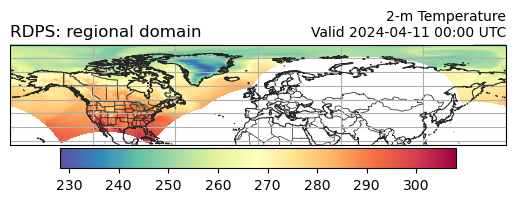

In [6]:
ax = EasyMap("50m").BORDERS().STATES(alpha=0.5).ax
p = ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, transform=pc, cmap="Spectral_r")
plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.01, shrink=0.8)
ax.set_title(
    f"2-m Temperature\nValid {ds.valid_time.dt.strftime('%Y-%m-%d %H:%M').item()} UTC",
    loc="right",
    fontsize=10,
)
ax.set_title(f"{ds.model.upper()}: {H.product_description}", loc="left")
ax.gridlines()

## Get 10-m U _and_ 10-m V wind


In [8]:
# loading more than one variable requires a loop, because the
# data is stored in multiple files (and a Herbie object only
# represents a single file).

store = []
for var, lev in zip(["UGRD", "VGRD"], ["TGL_10", "TGL_10"]):
    _ds = Herbie(
        recent,
        model="rdps",
        fxx=0,
        variable=var,
        level=lev,
    ).xarray()
    store.append(_ds)

ds = xr.merge(store)
ds

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F00 ┊ GRIB2 @ msc ┊ IDX @ None


/p/home/blaylock/BB_python/Herbie/herbie/core.py:1105: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F00 ┊ GRIB2 @ msc ┊ IDX @ None


/p/home/blaylock/BB_python/Herbie/herbie/core.py:1105: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


<xarray.Dataset> Size: 18MB
Dimensions:              (y: 824, x: 935)
Coordinates:
    time                 datetime64[ns] 8B 2024-04-11
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 10.0
    latitude             (y, x) float64 6MB 18.15 18.18 18.21 ... 45.49 45.41
    longitude            (y, x) float64 6MB 217.1 217.2 217.2 ... 349.8 349.8
    valid_time           datetime64[ns] 8B 2024-04-11
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 3MB ...
    gribfile_projection  object 8B None
    v10                  (y, x) float32 3MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    model:                   rdps
    product:                 10km/grib2/
    description:             Canada's Regional Deterministic Prediction Syste...
    remote_grib:             /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_UGRD...
    local_grib:              /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_UGRD...
    search:            None

In [9]:
# MetPy version >= 1.6 is required to parse the map projection
ds.herbie.crs

<Projected CRS: +proj=stere +ellps=sphere +a=6371229.0 +b=6371229. ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant B)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

<GeoAxes: >

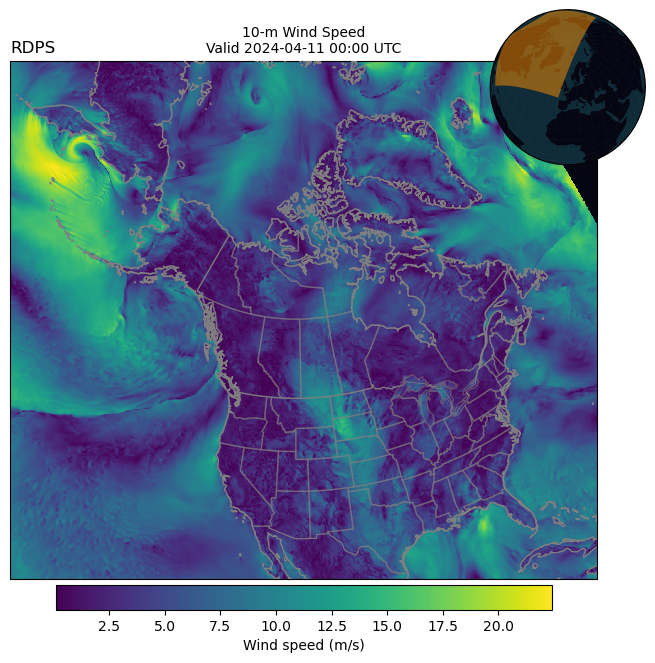

In [10]:
ax = (
    EasyMap("50m", crs=ds.herbie.crs, figsize=8, linewidth=1, theme="dark")
    .BORDERS()
    .STATES(alpha=0.5)
    .ax
)
p = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    np.hypot(ds.u10, ds.v10),  # Wind Speed
    transform=pc,
)
plt.colorbar(
    p, ax=ax, orientation="horizontal", pad=0.01, shrink=0.8, label="Wind speed (m/s)"
)

ax.set_title(
    f"10-m Wind Speed\nValid {ds.valid_time.dt.strftime('%Y-%m-%d %H:%M').item()} UTC",
    loc="center",
    fontsize=10,
)
ax.set_title(f"{ds.model.upper()}", loc="left")
ax.EasyMap.INSET_GLOBE()

## 500 hPa Humidity and Geopotential Height

(some weirdness in the data I don't understand)

In [11]:
# loading more than one variable requires a loop, because the
# data is stored in multiple files (and a Herbie object only
# represents a single file).

store = []
for var, lev in zip(["HGT", "RH"], ["ISBL_500", "ISBL_500"]):
    _ds = Herbie(
        recent,
        model="rdps",
        fxx=0,
        variable=var,
        level=lev,
    ).xarray()
    store.append(_ds)

ds = xr.merge(store)
ds

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F00 ┊ GRIB2 @ msc ┊ IDX @ None


/p/home/blaylock/BB_python/Herbie/herbie/core.py:1105: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2024-Apr-11 00:00 UTC F00 ┊ GRIB2 @ msc ┊ IDX @ None


/p/home/blaylock/BB_python/Herbie/herbie/core.py:1105: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


<xarray.Dataset> Size: 18MB
Dimensions:              (y: 824, x: 935)
Coordinates:
    time                 datetime64[ns] 8B 2024-04-11
    step                 timedelta64[ns] 8B 00:00:00
    isobaricInhPa        float64 8B 500.0
    latitude             (y, x) float64 6MB 18.15 18.18 18.21 ... 45.49 45.41
    longitude            (y, x) float64 6MB 217.1 217.2 217.2 ... 349.8 349.8
    valid_time           datetime64[ns] 8B 2024-04-11
Dimensions without coordinates: y, x
Data variables:
    gh                   (y, x) float32 3MB ...
    gribfile_projection  object 8B None
    r                    (y, x) float32 3MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    model:                   rdps
    product:                 10km/grib2/
    description:             Canada's Regional Deterministic Prediction Syste...
    remote_grib:             /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_HGT_...
    local_grib:              /p/cwfs/blaylock/data/rdps/20240411/CMC_reg_HGT_...
    search:            None

Text(0.0, 1.0, 'RDPS')

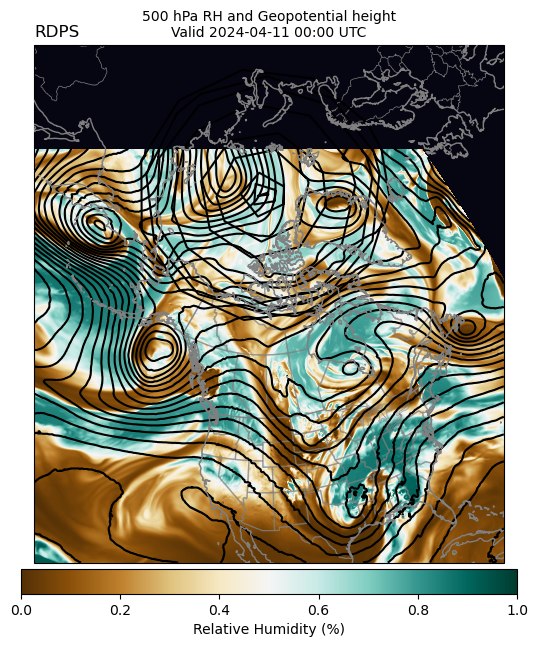

In [14]:
ax = (
    EasyMap("50m", crs=ds.herbie.crs, figsize=8, linewidth=1, theme="dark")
    .BORDERS()
    .STATES(alpha=0.5)
    .ax
)

# Draw Relative Humidity
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds.r, transform=pc, cmap="BrBG", vmin=0, vmax=1
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    label="Relative Humidity (%)",
)

# Draw Geopential Height Contours
ax.contour(
    ds.longitude,
    ds.latitude,
    ds.gh,
    colors="k",
    transform=pc,
    levels=range(0, 6000, 40),
)

ax.set_title(
    f"500 hPa RH and Geopotential height\nValid {ds.valid_time.dt.strftime('%Y-%m-%d %H:%M').item()} UTC",
    loc="center",
    fontsize=10,
)
ax.set_title(f"{ds.model.upper()}", loc="left")

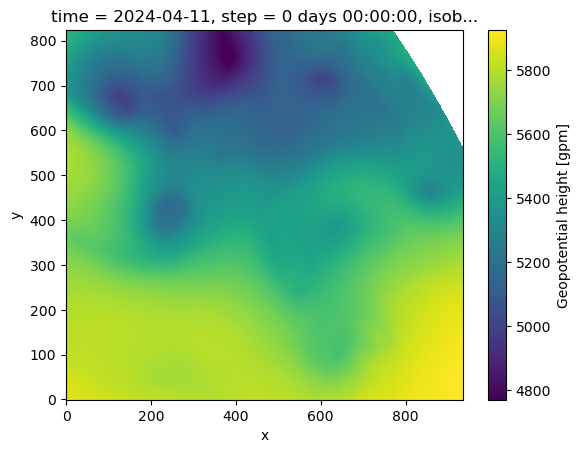

In [16]:
ds.gh.plot()

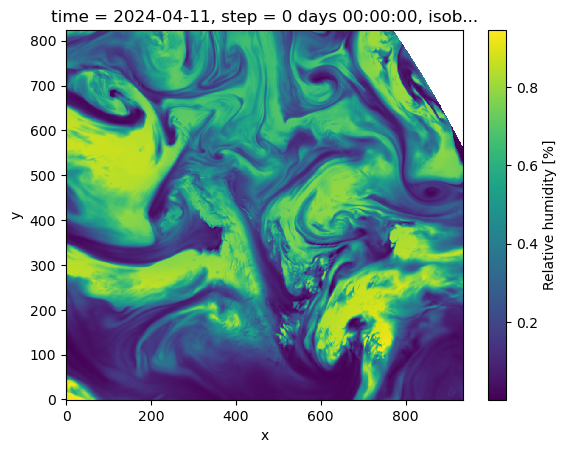

In [15]:
ds.r.plot()